In [50]:
# SECTION I: Importing all packages + Formatting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pandapower as pp
from pandapower.networks import case300
import random
import roman

plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'

## Set random seeds
random.seed(10)
np.random.seed(20)

In [51]:
# Labeling case
net = case300()

# Set maximum real power "p_mw" to some number
# Consider 200-500 range #
net.gen.max_p_mw = 320

# Set the sgen NOT in service
net.sgen.in_service = False
# maximum line and tranformer loading percent determine the convergence
# Set maximum line loading percentage
# Consider 50-100% range #
net.line.max_loading_percent = 65

# Set transformer loading percent as unlimited
net.trafo.max_loading_percent = 0
# Make sure case works
pp.rundcopp(net)

# Minimum max_p_mw of 320. Minimum net.line.max_loading_percent of ~0 #

c:\Users\gavin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\gavin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\gavin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, 

In [52]:
Case300_Data = pd.read_csv('C:/Users/gavin/Desktop/Case300_Data/case300_data_gavin.csv')
# Zone Identification + Loading Data
zone1 = np.array(Case300_Data['Zone']==1)
zone2 = np.array(Case300_Data['Zone']==2)
zone3 = np.array(Case300_Data['Zone']==3)
zone4 = np.array(Case300_Data['Zone']==4)

numzones = 4

In [53]:
# SECTION II: Nodal identifiers 

re_gen_no = Case300_Data['Regen'] == 1 # Get the element of renewable generators

# Get generator bus no (slack bus included)
gen_no = np.isin(net.bus.name-1, net.gen.bus)

# Get generator bus no (including renewable, thermal and slack buses)
slack_gen_no = np.isin(net.bus.name-1, net.gen.bus)

# Get load buses no
load_no = np.isin(net.bus.name-1, net.load.bus)

# Get buses which are both load and gen
load_gen_bus = net.load.bus[np.isin(net.load.bus, net.gen.bus)]

bus_features = ['p_mw']
p_bus_list = np.empty((net.bus.shape[0], len(bus_features)))
gen_features = ['p_mw']
p_gen_list = np.empty((net.gen.shape[0]*len(gen_features), 1))
p_max_gen_list = np.empty((net.gen.shape[0], 1))
p_load_list = np.empty((net.load.shape[0], 1))
line_features = ['p_from_mw']
pf_line_list = np.empty((net.line.shape[0]*len(line_features), 1))
lp_line_list = np.empty((net.line.shape[0], 1))
# The array to store slack bus 'max_p_mw'
p_slack_max_list = []

# Global features
shedding_reserve_list = []
total_cost_list = []

# Load data
for i in range(1, numzones+1):
    var_name = f'zone{i}_load_bidx'
    globals()[var_name] = np.isin(Case300_Data[Case300_Data['Load']==1].iloc[:,0],Case300_Data[(Case300_Data['Load']==1) & (Case300_Data['Zone']==i)].iloc[:,0])
    var_name = f'zone{i}_wind_bidx'
    globals()[var_name] = np.isin(Case300_Data[Case300_Data['Gen']==1].iloc[:,0],Case300_Data[(Case300_Data['Regen']==1) & (Case300_Data['Zone']==i)].iloc[:,0])
    var_name = f'zone{i}_gen_bidx'
    globals()[var_name] = np.isin(Case300_Data[Case300_Data['Gen']==1].iloc[:,0],Case300_Data[(Case300_Data['Gen']==1) & (Case300_Data['Zone']==i)].iloc[:,0])

# Thermal Generator Bus Data
th_gen_bus = Case300_Data[(Case300_Data['Regen']==0) & (Case300_Data['Gen']==1)].iloc[:,0]


In [54]:

## Number of Trials ##
num_rv = 500

mu = np.array([50, 75, 100, 48])
std = np.array([15, 20, 15, 12])
rv_min = np.array([10, 25, 60, 9])
rv_max = np.array([90, 125, 140, 87])

# Generate distributions and RVs
for i in range(1, numzones+1):
    # Left / right truncation in terms of standard deviation
    a = (rv_min[i-1] - mu[i-1]) / std[i-1]
    b = (rv_max[i-1] - mu[i-1]) / std[i-1]

    var_name = f'lx{i}'
    globals()[var_name] = np.linspace(rv_min[i-1], rv_max[i-1], num_rv)

    # Generate distributions
    var_name = f'tn{i}'
    globals()[var_name] = stats.truncnorm(loc=mu[i-1], scale=std[i-1], a=a, b=b)

    # Generate random variables and corresponding PDF
    var_name = f'tn_rv{i}'
    globals()[var_name] = globals()[f'tn{i}'].rvs(size=num_rv)
    var_name = f'tn_pdf{i}'
    globals()[var_name] = globals()[f'tn{i}'].pdf(x=globals()[f'lx{i}'])

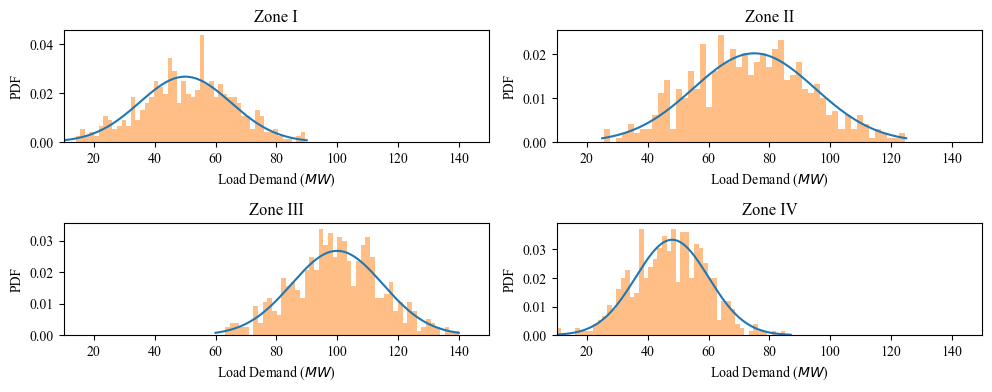

In [55]:
## Plot load RVs
fig = plt.figure(figsize=(10, 4))

for i in range(1, numzones+1):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(globals()[f'lx{i}'], globals()[f'tn_pdf{i}'])
    _, _, _ = ax.hist(globals()[f'tn_rv{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(10, 150)
    ax.set_xlabel('Load Demand ($MW$)')
    ax.set_ylabel('PDF')
    ax.set_title(f'Zone {roman.toRoman(i)}')
    plt.tight_layout(pad=1)

plt.show()
plt.close('all')

In [56]:
## WIND ##
## Define func wind speed --> wind energy
def windSpeedToPower(w):
    """
        input:
            w: wind speed (m/s), ndarray
        output:
            P: wind power (MW), ndarray
    """
    # Check the input type
    if type(w) != np.ndarray:
        raise TypeError("'w' should be 'numpy.ndarray'.")
    # Set maximum allowed wind power generation
    Pr = 100.
    # No wind power if w < wi
    wi = 1.
    # Wind speed that reaches maximum allowed wind power capacity
    wr = 15.
    # Convert wind speed to wind power
    P = Pr*(w**3 - wi**3)/(wr**3 - wi**3)
    # Get index of wind speed less than wi
    left_index = (w < wi)
    P[left_index] = 0.
    # Get index of wind speed bigger than wi
    right_index = (w > wr)
    P[right_index] = Pr

    return P

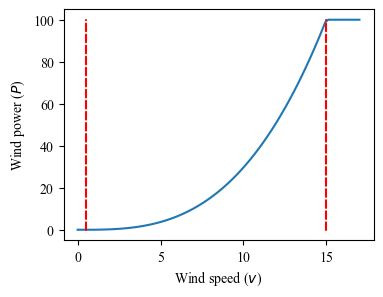

In [57]:
w = np.linspace(0, 17, 100)
P = windSpeedToPower(w)
plt.plot(w, P)
plt.vlines(x=0.5, ymin=0, ymax = 100, color='red', linestyles='dashed')
plt.vlines(x=15., ymin=0, ymax = 100, color='red', linestyles='dashed')
plt.xlabel('Wind speed ($v$)')
plt.ylabel('Wind power ($P$)')
plt.show()
plt.close('all')

In [58]:
# Set parameters
loc = 0.
scale = np.array([8, 8.2, 12, 8.1])
shape = np.array([2, 1.8, 8, 1.9])

# Generate distributions and RVs
lx = np.linspace(0, 30, num_rv)

for i in range(1, numzones+1):
    # Generate distributions
    var_name = f'twb{i}'
    globals()[var_name] = stats.weibull_min(loc=loc, c=shape[i-1], scale=scale[i-1])

    # Generate random variables and corresponding PDF
    var_name = f'twb_rv{i}'
    globals()[var_name] = globals()[f'twb{i}'].rvs(size=num_rv)
    var_name = f'twb_pdf{i}'
    globals()[var_name] = globals()[f'twb{i}'].pdf(x=lx)

    # Conver wind speed to wind power
    var_name = f'wind_power{i}'
    globals()[var_name] = windSpeedToPower(globals()[f'twb_rv{i}'])

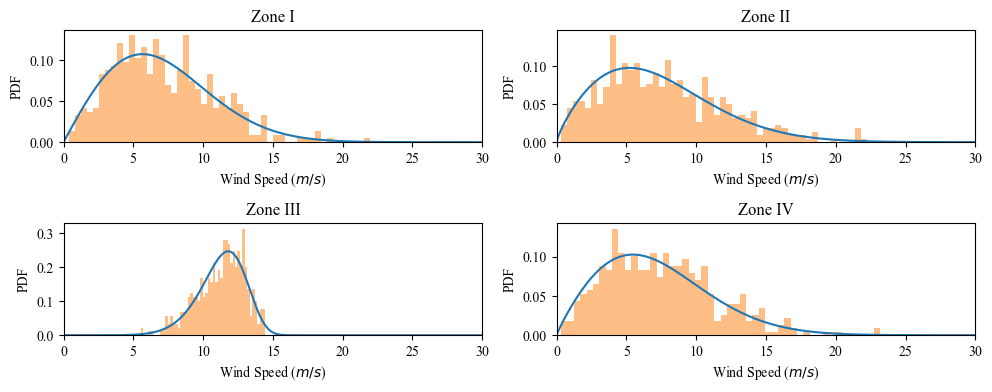

In [59]:
## Plot wind speed RVs
fig = plt.figure(figsize=(10, 4))

for i in range(1, numzones+1):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(lx, globals()[f'twb_pdf{i}'])
    _, _, _ = ax.hist(globals()[f'twb_rv{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(0, 30)
    ax.set_xlabel('Wind Speed ($m/s$)')
    ax.set_ylabel('PDF')
    ax.set_title(f'Zone {roman.toRoman(i)}')
    plt.tight_layout(pad=1)

plt.show()
plt.close('all')

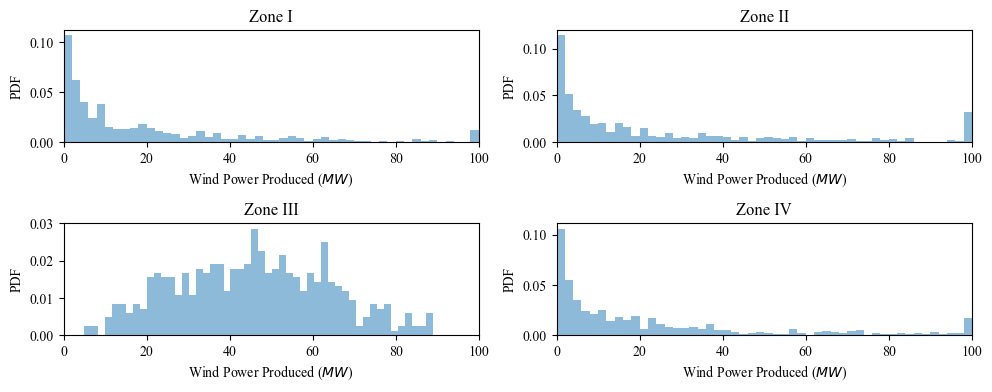

In [60]:
## Plot wind power
fig = plt.figure(figsize=(10, 4))

for i in range(1, numzones+1):
    ax = fig.add_subplot(2, 2, i)
    _, _, _ = ax.hist(globals()[f'wind_power{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(0, 100)
    ax.set_xlabel('Wind Power Produced ($MW$)')
    ax.set_ylabel('PDF')
    ax.set_title(f'Zone {roman.toRoman(i)}')
    plt.tight_layout(pad=1)

plt.show()
plt.close('all')

In [61]:
## Correlation Matrix ##

## Input variables of power demand in load (tn_rv{i})) and regen power (wind_power{i})
Corr_Matrix = np.corrcoef(np.column_stack((wind_power1, tn_rv1, wind_power2, tn_rv2, wind_power3, tn_rv3, wind_power4, tn_rv4)), rowvar = False)

## load /wind proportions
for i in range(1, numzones+1):
    np.random.seed(10)
    var_name = f'zone{i}_load_proportion'
    globals()[var_name] = np.random.uniform(0.5, 1.4, size = len(Case300_Data[(Case300_Data['Load']==1) & (Case300_Data['Zone']==i)].iloc[:,0]))

    # Z1 has 44 load buses, Z2 has 57, Z3 has 41, and Z4 has 51
    
    np.random.seed(10)
    var_name = f'zone{i}_wind_proportion'   
    globals()[var_name] = np.random.uniform(0.5, 1.4, size = len(Case300_Data[(Case300_Data['Regen']==1) & (Case300_Data['Zone']==i)].iloc[:,0]))

    # Z1 has 2 regen buses, Z2 and Z3 have 3 each, and Z4 has 5

# Reset random seed
np.random.seed()


In [62]:
## Number of grid variable samples
max_iteration = 2000

## Numbe rof target OPF samples (solutions)
num_samples = 50

## Generate correlated RV
# Generate multivariate normal PDF (Standard normal PDF --> covariance = correlation)
mvnorm = stats.multivariate_normal(cov=Corr_Matrix)
mvnorm_rv = mvnorm.rvs(size=max_iteration)
# Get corresponding CDF (CANNOT USE MULTIVARIATE_NOMRAL CDF)
rv_cdf = stats.norm.cdf(mvnorm_rv)
# Generate RV under target PDFs using inverse CDF
for i in range(1, numzones+1):
    var_name = f'L{i}_ref'
    globals()[var_name] = globals()[f'tn{i}'].ppf(rv_cdf[:, i-1])
    var_name = f'R{i}_ref'
    globals()[var_name] = windSpeedToPower(globals()[f'twb{i}'].ppf(rv_cdf[:, 0]))

In [79]:
len(net.load.p_mw[zone1_load_bidx])

44

In [63]:
# Set RV index
j = 0   # Index for max_iteration
num = 0 # Index for OPF solutions
while j < max_iteration:
    ## Set p_mw at load buses and max_p_mw / min_p_mw at wind buses
    for i in range(1, numzones+1):
        # Generate values for the rest of loads and RES
        var_name = f'L_{i}'
        globals()[var_name] = globals()[f'L{i}_ref'][j] * globals()[f'zone{i}_load_proportion']
        var_name = f'R_{i}'
        globals()[var_name] = globals()[f'R{i}_ref'][j] * globals()[f'zone{i}_wind_proportion']

        # Set p_mw at load buses
        net.load.p_mw[globals()[f'zone{i}_load_bidx']] = globals()[f'L_{i}']

        # Set max_p_mw adn min_p_mw at wind buses
        net.gen.max_p_mw[globals()[f'zone{i}_wind_bidx']] = globals()[f'R_{i}']
        net.gen.min_p_mw[globals()[f'zone{i}_wind_bidx']] = globals()[f'R_{i}']
    
    # Set 'max_p_mw' at slack bus 
    if net.load.p_mw.sum() >= net.gen.max_p_mw.sum():
        net.ext_grid.max_p_mw = net.load.p_mw.sum() - net.gen.max_p_mw.sum()
    else:
        net.ext_grid.max_p_mw = 0.

    ## Run OPF solver (ignore unconverged cases) and collect data
    try:
        ## Run DCOPP
        pp.rundcopp(net)

        ## Collect data
        # p_mw at load buses
        p_load = net.load.p_mw.to_numpy().reshape((-1, 1))
        p_load_list = np.concatenate([p_load_list, p_load], axis=1)
        # max_p_mw at gen buses
        p_max_gen = net.gen.max_p_mw.to_numpy().reshape((-1, 1))
        p_max_gen_list = np.concatenate([p_max_gen_list, p_max_gen], axis=1)
        # max_p_mw at slack bus
        p_slack_max_list.append(net.ext_grid.max_p_mw.values)

        ## Collect results
        # Results of p_mw at all buses
        # order='F' means first index changes fastest while last index changes slowest
        p_bus = net.res_bus[bus_features].to_numpy().reshape((-1, len(bus_features)), order='F') 
        p_bus_list = np.concatenate([p_bus_list, p_bus], axis=1)
        # Results of p_mw at gen buses
        p_gen = net.res_gen[gen_features].to_numpy().reshape((-1, 1), order='F')  
        p_gen_list = np.concatenate([p_gen_list, p_gen], axis=1)
        # Results of power flow at all lines
        pf_line = net.res_line[line_features].to_numpy().reshape((-1, 1), order='F')
        pf_line_list = np.concatenate([pf_line_list, pf_line], axis=1)
        # Results of loading percent at all lines
        lp_line = net.res_line.loading_percent.to_numpy().reshape((-1, 1))
        lp_line_list = np.concatenate([lp_line_list, lp_line], axis=1)
        # Results of shedding and reserve
        shedding_reserve = net.load.p_mw.sum() - net.gen.max_p_mw.sum()
        shedding_reserve_list.append(shedding_reserve)
        # Results of total cost
        total_cost = net.res_cost / 1e3
        total_cost_list.append(total_cost)

        # Increment index
        num += 1

        if num >= num_samples:
            print(f'{num_samples} OPF solutions found')
            break
    except:
        print(f'No solution found for sample {j+1}')
        pass

    # Increment index
    j += 1

    # Increment index
    if j >= max_iteration:
        print(f'No sufficient samples found for {num_samples} OPF solutions')
        break

C:\Users\gavin\AppData\Local\Temp\ipykernel_54312\1422931552.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  net.load.p_mw[globals()[f'zone{i}_load_bidx']] = globals()[f'L_{i}']
C:\Users\gavin\AppData\Local\Temp\ipykernel_54312\14229315

50 OPF solutions found


In [64]:
# Save synthetic data (node level)
pd.DataFrame(p_load_list[:, 1:]).to_csv('synthetic_data/p_load_data.csv')
pd.DataFrame(p_max_gen_list[:, 1:]).to_csv('synthetic_data/p_max_gen_data.csv')
pd.DataFrame(p_slack_max_list).to_csv('synthetic_data/p_slack_max_data.csv')
pd.DataFrame(p_bus_list[:, len(bus_features):]).to_csv('synthetic_data/p_bus_data.csv')
pd.DataFrame(p_gen_list[:, 1:]).to_csv('synthetic_data/p_gen_data.csv')

# Save synthetic data (edge level)
pd.DataFrame(pf_line_list[:, 1:]).to_csv('synthetic_data/pf_line_data.csv')
pd.DataFrame(lp_line_list[:, 1:]).to_csv('synthetic_data/lp_line_data.csv')

pd.DataFrame(lp_line_list[:, 1:]).to_csv('reliability_risk/lp_true_corr.csv')

# Save synthetic data (graph level)
graph_features = pd.concat([pd.Series(shedding_reserve_list, name='shedding_reserve'), 
                           pd.Series(total_cost_list, name='total_cost(10^3)')], 
                           axis=1)
graph_features.T.to_csv('synthetic_data/graph_features.csv')

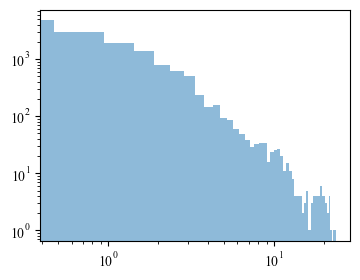

In [65]:
lp_line = pd.DataFrame(lp_line_list[:, 1:])
_, _, _ = plt.hist(lp_line.values.flatten(), bins=50, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close('all')